<a href="https://colab.research.google.com/github/SSulaimanW345/Foodie-AI/blob/master/05_FoodVision_Food101_Tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Artificial Intelligence Project


---



## Title: Foodie


> Image Classification on dataset: FOOD101


###Submission date: 02/05/2023
###Member(s):Syed Sulaiman





##What are we trying to achieve ?

We're going to be building Foodie™, using all of the data from the Food101 dataset.

The **goal is to of beat DeepFood**, a 2016 paper which used a Convolutional Neural Network trained for 2-3 days to achieve 77.4% top-1 accuracy.


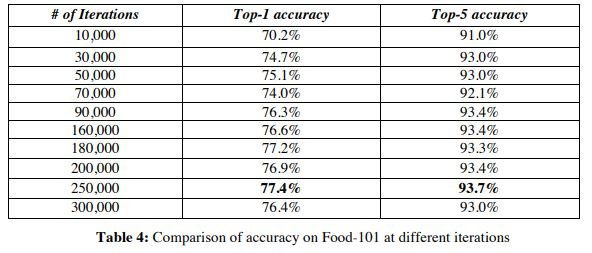


URL [paper] : https://www.researchgate.net/publication/304163308_DeepFood_Deep_Learning-Based_Food_Image_Recognition_for_Computer-Aided_Dietary_Assessment 








##What will be covered in this project:
* **Tensorflow** library
* Tensorflow **dataset:FOOD101** downloaded and explored from https://www.tensorflow.org/datasets/catalog/overview 
* Creating **preprocessing functions** to prepare data to be used by our model.
* Developing a Tensorflow **data input pipelines** for optimizing performance **[prefetching]**
* Batching & preparing datasets for modelling
* Creating  modelling callbacks **i.e TensorBoard ,  ModelCheckpoint ,   EarlyStopping**
* Making use of a new Tensorflow feature called **MIXED TRAINING** for efficient training.
* Using a Pre-triained model **EfficientNet** - (a state of the art computer vision architecture from 2019)
* Building and training a **Feature extraction model** for our Classifcation problem.
* **Fine-tuning** the feature extraction model developed.
* Using **TENSOR BOARD** to visualize our model(s) training results.

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.12.0


##Peek into the dataset: FOOD101

✅ What ChatGPT tells us about FOOD101?



> The Food-101 is a challenging data set of 101 food categories with 101,000 images. For each class, 250 manually reviewed test images are provided as well as 750 training images. On purpose, the training images were not cleaned, and thus still contain some amount of noise. This comes mostly in the form of intense colors and sometimes wrong labels. All images were rescaled to have a maximum side length of 512 pixels.

* 101 classes i.e food categories
* 1000 images per class
* 750 training and 250 test images per class
* Available in tensorflow_datasets
* Total of 100k above images

---


##Let's Load and Explore the dataset for better understanding !




In [7]:
import tensorflow_datasets as tfds
import tensorflow as tf

#check to see FOOD101 available in tensorflow datasets
availableDatasets = tfds.list_builders()
status  = "food101" in availableDatasets
print(status)

True


In [62]:
# load the DATASET food101 from tensor_flow datasets using the LOAD method

(trainData, testData), metaData = tfds.load(name="food101",
                                            split = ["train","validation"],
                                            shuffle_files=False,
                                            as_supervised=True,
                                            with_info= True,
                                            )


In [63]:
# metaData object has the information regarding the DATASET
print("The features dictionary")
print(metaData.features)
classesAvailable = metaData.features["label"].names
print(f"\n TOtal number of classes {len(classesAvailable)} \n")
print(classesAvailable)

print(f"\n Number of images in training dataset {len(trainData)}")
print(f"\n Number of images in Test dataset {len(testData)}")



The features dictionary
FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

 TOtal number of classes 101 

['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito', 'bruschetta', 'caesar_salad', 'cannoli', 'caprese_salad', 'carrot_cake', 'ceviche', 'cheesecake', 'cheese_plate', 'chicken_curry', 'chicken_quesadilla', 'chicken_wings', 'chocolate_cake', 'chocolate_mousse', 'churros', 'clam_chowder', 'club_sandwich', 'crab_cakes', 'creme_brulee', 'croque_madame', 'cup_cakes', 'deviled_eggs', 'donuts', 'dumplings', 'edamame', 'eggs_benedict', 'escargots', 'falafel', 'filet_mignon', 'fish_and_chips', 'foie_gras', 'french_fries', 'french_onion_soup', 'french_toast', 'fried_calamari', 'fried_rice', 'frozen_yogurt', 'garlic_bread', 'gnocchi', 'greek_salad', 'grilled_cheese_sandwich', 'grilled_salmon', 'guacamole', 

In [12]:
# lets see what our data looks like

for image,label in trainData.take(1):
  print(f"""
  Image shape: {image.shape}
  Image dtype: {image.dtype}
  Target class: {label}
  class name : {classesAvailable[label.numpy()]}
  
  """)

# the image dtype is unit8, we will have to change it.
# Look at the image tensors, what do you notice
image.numpy()

tf.reduce_min(image), tf.reduce_max(image)



  Image shape: (512, 384, 3)
  Image dtype: <dtype: 'uint8'>
  Target class: 19
  class name : chicken_quesadilla
  
  


(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)


    Image shape: (512, 289, 3)
    Image dtype: <dtype: 'uint8'>
    


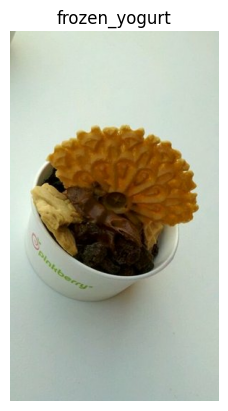

In [13]:
# We can visualize our data 
# Lets use a function to plot random images in the dataset
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
def plot_random_image(data):
  for image,label in data.take(1):
    print(f"""
    Image shape: {image.shape}
    Image dtype: {image.dtype}
    """)
  plt.imshow(image)
  plt.title(classesAvailable[label.numpy()])
  plt.axis("off")

plot_random_image(trainData)

##What is not right about our data?

1. datatype is `uint8`
2. Image sizes are not same
3. Not normalized pixel values

###Let's preprocess our DATA
We will create a function that will preprocess all our images to be used in the model 

* Images to be in `float32` format
* Image size i.e tensor size must be the same for all images (*we choose 224, 224*)
* Normalize all images

In [14]:
def prepare_data(img, label,size=224):
   img = tf.image.resize(img, [size, size]) 
   #img= img/255.
   return tf.cast(img, tf.float32), label 


preparedImg = prepare_data(image, label,224)[0]
print(f"Image before preprocessing:\n {image[:2]}...,\nShape: {image.shape},\nDatatype: {image.dtype}\n")
print(f"Image after preprocessing:\n {preparedImg[:2]}...,\nShape: {preparedImg.shape},\nDatatype: {preparedImg.dtype}")

Image before preprocessing:
 [[[ 0  0  0]
  [ 0  0  0]
  [ 0  0  0]
  ...
  [ 7  7  5]
  [11 11  9]
  [14 14 12]]

 [[ 0  0  0]
  [ 0  0  0]
  [ 0  0  0]
  ...
  [ 5  5  3]
  [ 8  8  6]
  [11 11  9]]]...,
Shape: (512, 384, 3),
Datatype: <dtype: 'uint8'>

Image after preprocessing:
 [[[ 0.         0.         0.       ]
  [ 0.         0.         0.       ]
  [ 0.         0.         0.       ]
  ...
  [ 7.7907934  7.7907934  5.7907934]
  [ 5.714286   5.714286   3.7142856]
  [10.999987  10.999987   8.999987 ]]

 [[ 0.         0.         0.       ]
  [ 0.         0.         0.       ]
  [ 0.         0.         0.       ]
  ...
  [ 6.770399   6.770399   4.770399 ]
  [ 6.790833   6.790833   4.790833 ]
  [10.1887665 10.1887665  8.1887665]]]...,
Shape: (224, 224, 3),
Datatype: <dtype: 'float32'>


##Build TensorFlow input pipelines
So, we are done with preprocessing data ❗


Now let's create a data pipleine to improve performance and efficiency of training 

What will we do:
* Create batches of dataset
* Use prefetching
* Shuffling
* Caching (not possible)
* Mapping function that allows us to call our predefined function `prepare_data()`

In [65]:
trainData = trainData.map(map_func=prepare_data, num_parallel_calls=tf.data.AUTOTUNE)
trainData = trainData.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)
testData = testData.map(prepare_data, num_parallel_calls=tf.data.AUTOTUNE)
testData = testData.batch(32).prefetch(tf.data.AUTOTUNE)

# Now see what our prefetched dataset looks like

trainData, testData

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

##Adding Callbacks to track and save model progress

⏹ Callbacks we will be using:

* TensorBoard
* ModelCheckpoint
* EarlyStopping



In [38]:
checkpointPath = "/Foodie/model_checkpoints/cp.ckpt"
tensorBoardpath = "/Foodie/tensor_board/"

tensorboardCallback = tf.keras.callbacks.TensorBoard(log_dir=tensorBoardpath)

modelCheckpoint = tf.keras.callbacks.ModelCheckpoint(checkpointPath,
                                                      monitor="val_accuracy", 
                                                      save_best_only=True, 
                                                      save_weights_only=True,
                                                      verbose=0) 
earlyStopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3)
reduceLr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",  factor=0.2,patience=2,verbose=1, min_lr=1e-7)


##Why will be using mixed precision ❓

 It works by storing data and performing calculations in different precisions, depending on their importance. For example, less important data may be stored in lower precision, while more important data may be stored in higher precision.

🔑** Mixed precision** training has several advantages over single-precision training, including:

* Speed: Mixed precision training can be up to 2x faster than single-precision training, because it requires fewer operations.
Memory: Mixed precision training can use less memory than single-precision training, because it requires less storage space for less important data.
* Accuracy: Mixed precision training can achieve the same accuracy as single-precision training, as long as the important data is stored in high precision.
* Mixed precision training is a powerful technique that can be used to improve the performance and efficiency of AI models. It is especially useful for training large and complex models, such as those used for natural language processing and computer vision.

In addition to the advantages mentioned above, mixed precision training can also help to improve the stability of training. This is because lower precision calculations are less susceptible to rounding errors, which can cause training to diverge.


---


###What GPU do we need?

🔑 Note: Not all GPU are compatible with mixed precision training.
 P100 and K80 aren't compatible.

 **TESLA T4 is compatible (using in COLAB)**



In [9]:
!nvidia-smi

Mon May  1 09:30:38 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   76C    P0    33W /  70W |    403MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [36]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy(policy="mixed_float16")
mixed_precision.global_policy()

<Policy "mixed_float16">

##Finally, building FEATURE EXTRACTION MODEL ❗



---

###What model are we using?

> Predefined  **EfficientNetB0 from tf.keras.applications**

###**EfficientNetB0** details

* EfficientNetB0 has a total of about 5.3 million parameters and achieves an accuracy of around 76.3% on the ImageNet benchmark dataset (with 224x224 pixel input images).
* EfficientNetB0 supports input images with resolutions ranging from 224x224 to 600x600 pixels, and can be fine-tuned for other computer vision tasks, such as object detection and segmentation.
* EfficientNetB0 is a convolutional neural network architecture designed by Tan and Le (2019) that achieves state-of-the-art accuracy on image classification benchmarks while requiring fewer parameters and computations compared to previous models.
* Architecture


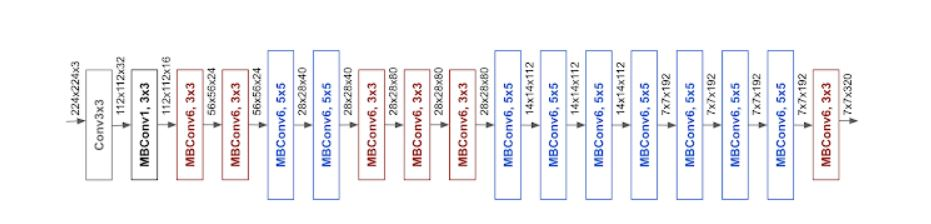

URL to read more: https://ai.googleblog.com/2019/05/efficientnet-improving-accuracy-and.html




In [37]:
from tensorflow.keras import layers
import tensorflow as tf

base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False
input_shape = (224, 224, 3)

inputs = layers.Input(shape=input_shape, name="inputLayer")
x = base_model(inputs, training=False) 
x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)
x = layers.Dense(len(classesAvailable))(x)
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x) 
model = tf.keras.Model(inputs, outputs)

model.compile(loss="sparse_categorical_crossentropy", 
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputLayer (InputLayer)     [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 pooling_layer (GlobalAverag  (None, 1280)             0         
 ePooling2D)                                                     
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                               
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

In [43]:

# Fit the model with callbacks
historyEfficientNetB0 = model.fit(trainData,epochs=3,steps_per_epoch=len(trainData),validation_data=testData,validation_steps=int(0.15 * len(testData)),
                                                     callbacks=[tensorboardCallback,modelCheckpoint])


Epoch 1/3
  97/2368 [>.............................] - ETA: 2:26 - loss: 1.0802 - accuracy: 0.7216

KeyboardInterrupt: ignored

In [42]:
import os
save_dir = "drive/MyDrive/foodie/featureExtraction/"
#os.makedirs(save_dir) # Make directory if it doesn't exist
model.save(save_dir)


TypeError: ignored

##Fine-Tuning our model 



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [35]:
from tensorflow.keras import layers
import tensorflow as tf

base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = True

inputs = layers.Input(shape=(224,224,3), name="inputLayer")
x = base_model(inputs, training=False) 
x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)
x = layers.Dense(len(classesAvailable))(x)
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x) 
model_2 = tf.keras.Model(inputs, outputs)
model_2.compile(loss="sparse_categorical_crossentropy", 
                        optimizer=tf.keras.optimizers.Adam(0.0001),
                        metrics=["accuracy"])

16705208/16705208 [==============================] - 0s 0us/step


In [ ]:
historyEfficientNetB0_finetuned = model_2.fit(trainData,
                                                        epochs=100, 
                                                        steps_per_epoch=len(trainData),
                                                        validation_data=testData,
                                                        validation_steps=int(0.15 * len(testData)), 
                                                        callbacks=[tensorboardCallback, modelCheckpoint, earlyStopping, reduceLr])

Epoch 1/100
2368/2368 [==============================] - 426s 156ms/step - loss: 1.6499 - accuracy: 0.5827 - val_loss: 0.9027 - val_accuracy: 0.7497 - lr: 1.0000e-04
Epoch 2/100
2368/2368 [==============================] - 367s 154ms/step - loss: 0.8600 - accuracy: 0.7674 - val_loss: 0.7325 - val_accuracy: 0.7932 - lr: 1.0000e-04
Epoch 3/100
2368/2368 [==============================] - 366s 154ms/step - loss: 0.5500 - accuracy: 0.8444 - val_loss: 0.7556 - val_accuracy: 0.7905 - lr: 1.0000e-04
Epoch 4/100
2368/2368 [==============================] - ETA: 0s - loss: 0.3244 - accuracy: 0.9050
Epoch 4: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
2368/2368 [==============================] - 369s 155ms/step - loss: 0.3244 - accuracy: 0.9050 - val_loss: 0.8097 - val_accuracy: 0.7897 - lr: 1.0000e-04
Epoch 5/100
2368/2368 [==============================] - 369s 155ms/step - loss: 0.0842 - accuracy: 0.9783 - val_loss: 0.8499 - val_accuracy: 0.8175 - lr: 2.0000e-05


In [ ]:
save_dir = "drive/MyDrive/foodie/fineTuned/"
model_2.save(save_dir)

In [ ]:
!tensorboard dev upload --logdir ./training_logs --name "Fine-tuning EfficientNetB0 on all Food101 Data" \--description "Training results for fine-tuning EfficientNetB0 on Food101 Data " \--one_shot

In [ ]:
#plotting loss and accuracy curves to visualize our model
def plotModelcurves(hist):
  """
  Returns separate loss curves for training and validation metrics.
  """ 
  loss = hist.history['loss']
  valLoss = hist.history['val_loss']
  accuracy = hist.history['accuracy']
  valAccuracy = hist.history['val_accuracy']
  epochs = range(len(hist.history['loss']))
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, valAccuracy, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, valAccuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

#plotModelcurves(historyEfficientNetB0_finetuned)



NameError: ignored

In [66]:
import tensorflow as tf
#import my custom model

myCustomModel = tf.keras.models.load_model('/content/drive/MyDrive/my_model.h5')

##Evaluating Our Fine-tuned Model

###We will use:
* ✅ Accuracy 
* Confusion matrix
* Classification report (F1-scores)

In [67]:
#Making predictions
predOutcomes = myCustomModel.predict(testData, verbose=1)
len(predOutcomes)

790/790 [==============================] - 55s 67ms/step


25250

In [24]:
loaded_loss, loaded_accuracy = myCustomModel.evaluate(testData)
loaded_loss, loaded_accuracy

790/790 [==============================] - 54s 66ms/step - loss: 0.9072 - accuracy: 0.8015


(0.9072167873382568, 0.8014653325080872)

##What is a confusion matrix ❓

A confusion matrix is a summary of prediction results on a classification problem.

The number of correct and incorrect predictions are summarized with count values and broken down by each class. This is the key to the confusion matrix.


**The confusion matrix shows the ways in which your classification model
is confused when it makes predictions.**

* “true positive” for correctly predicted event values.
* “false positive” for incorrectly predicted event values.
* “true negative” for correctly predicted no-event values.
* “false negative” for incorrectly predicted no-event values.

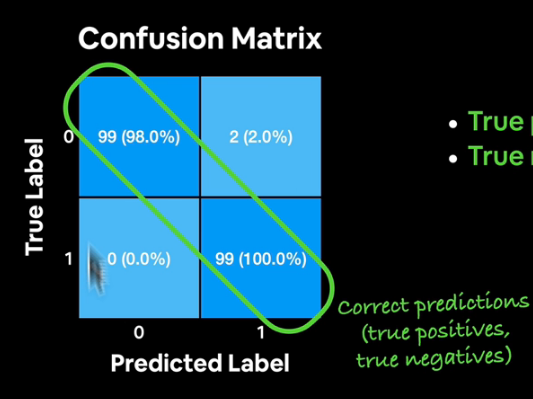




In [68]:
from sklearn.metrics import accuracy_score

predClasses = predOutcomes.argmax(axis=1)
y_labels = []
for images, labels in testData.unbatch(): 
  y_labels.append(labels.numpy()) 
print(y_labels)
accuracyCheck = accuracy_score(y_labels, predClasses)
accuracyCheck

[29, 81, 91, 53, 97, 97, 10, 31, 3, 100, 4, 32, 32, 3, 8, 85, 84, 60, 29, 80, 32, 78, 17, 1, 40, 40, 99, 1, 71, 42, 6, 44, 15, 49, 12, 7, 33, 52, 69, 54, 88, 50, 53, 3, 38, 6, 84, 70, 93, 83, 98, 40, 60, 13, 36, 92, 21, 25, 29, 81, 66, 81, 1, 92, 83, 16, 60, 32, 36, 94, 48, 0, 65, 29, 56, 37, 87, 65, 64, 26, 1, 75, 61, 74, 54, 76, 34, 90, 15, 4, 15, 19, 49, 100, 93, 62, 37, 99, 40, 60, 1, 69, 52, 62, 77, 67, 12, 96, 53, 70, 44, 71, 83, 80, 45, 28, 23, 30, 72, 45, 94, 92, 46, 18, 99, 75, 16, 40, 65, 70, 34, 69, 23, 78, 13, 41, 27, 41, 32, 25, 5, 20, 53, 59, 44, 27, 79, 16, 51, 12, 17, 99, 13, 42, 24, 54, 36, 80, 26, 68, 90, 33, 9, 12, 78, 77, 96, 6, 48, 9, 38, 74, 52, 7, 26, 90, 42, 57, 46, 69, 100, 38, 10, 86, 16, 83, 63, 27, 36, 66, 76, 9, 57, 48, 79, 44, 81, 43, 27, 47, 46, 22, 99, 70, 100, 90, 21, 59, 3, 73, 22, 59, 12, 39, 90, 6, 23, 44, 39, 6, 77, 56, 96, 42, 28, 12, 4, 66, 55, 32, 19, 42, 63, 91, 16, 97, 79, 41, 95, 4, 78, 100, 79, 4, 37, 14, 42, 69, 30, 44, 17, 44, 22, 77, 17, 6

0.8014653465346535

In [72]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] 
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) 
  fig.colorbar(cax)
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
    ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  plt.xticks(rotation=70, fontsize=text_size)
  plt.yticks(fontsize=text_size)
  threshold = (cm.max() + cm.min()) / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
  if savefig:
    fig.savefig("confusion_matrix.png")

make_confusion_matrix(y_true=y_labels,
                      y_pred=predClasses,
                      classes=classesAvailable,
                      figsize=(100, 100),
                      text_size=20,
                      norm=False,
                      savefig=True)      



##SKlearn Classfication report 📑

A Classification report is used to measure the quality of predictions from a classification algorithm. How many predictions are True and how many are False. More specifically, True Positives, False Positives, True negatives and False Negatives are used to predict the metrics of a classification report as shown below.

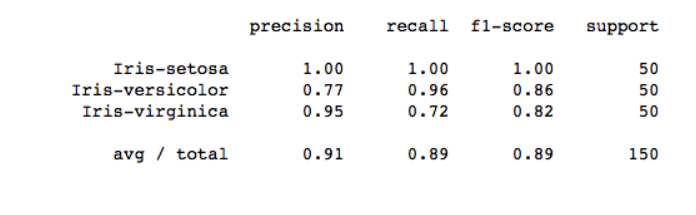

In [73]:

from sklearn.metrics import classification_report
print(classification_report(y_labels, predClasses))

              precision    recall  f1-score   support

           0       0.62      0.62      0.62       250
           1       0.81      0.77      0.79       250
           2       0.85      0.86      0.85       250
           3       0.81      0.83      0.82       250
           4       0.73      0.75      0.74       250
           5       0.74      0.67      0.70       250
           6       0.86      0.83      0.84       250
           7       0.90      0.91      0.91       250
           8       0.64      0.60      0.62       250
           9       0.80      0.70      0.74       250
          10       0.80      0.71      0.75       250
          11       0.83      0.84      0.84       250
          12       0.87      0.84      0.86       250
          13       0.73      0.84      0.78       250
          14       0.76      0.80      0.78       250
          15       0.68      0.68      0.68       250
          16       0.65      0.68      0.66       250
          17       0.83    

In [74]:
classification_report_dict = classification_report(y_labels, predClasses, output_dict=True)
classification_report_dict

{'0': {'precision': 0.6184738955823293,
  'recall': 0.616,
  'f1-score': 0.6172344689378757,
  'support': 250},
 '1': {'precision': 0.8075313807531381,
  'recall': 0.772,
  'f1-score': 0.7893660531697343,
  'support': 250},
 '2': {'precision': 0.8464566929133859,
  'recall': 0.86,
  'f1-score': 0.8531746031746033,
  'support': 250},
 '3': {'precision': 0.8093385214007782,
  'recall': 0.832,
  'f1-score': 0.8205128205128205,
  'support': 250},
 '4': {'precision': 0.7315175097276264,
  'recall': 0.752,
  'f1-score': 0.7416173570019725,
  'support': 250},
 '5': {'precision': 0.7400881057268722,
  'recall': 0.672,
  'f1-score': 0.7044025157232704,
  'support': 250},
 '6': {'precision': 0.8625,
  'recall': 0.828,
  'f1-score': 0.8448979591836734,
  'support': 250},
 '7': {'precision': 0.9011857707509882,
  'recall': 0.912,
  'f1-score': 0.9065606361829026,
  'support': 250},
 '8': {'precision': 0.6367521367521367,
  'recall': 0.596,
  'f1-score': 0.6157024793388429,
  'support': 250},
 '9':

##Finally, Testing on actual images

Visualizing predictions on actual images. You can look at all the metrics you want but until you've visualized some predictions, you won't really know how your model is performing.

In [27]:
def load_and_prep_image(filename, img_shape=224, scale=True):

  img = tf.io.read_file(filename)
  img = tf.io.decode_image(img)
  img = tf.image.resize(img, [img_shape, img_shape])
  if scale:
    return img/255.
  else:
    return img

In [ ]:
#creating a pkl file for deployment
import joblib
joblib.dump(myCustomModel, 'model.pkl')

['model.pkl']

In [29]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-steak.jpeg 


--2023-05-01 09:50:05--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-steak.jpeg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1978213 (1.9M) [image/jpeg]
Saving to: ‘03-steak.jpeg.1’

03-steak.jpeg.1     100%[===================>]   1.89M  --.-KB/s    in 0.03s   

2023-05-01 09:50:05 (60.9 MB/s) - ‘03-steak.jpeg.1’ saved [1978213/1978213]



1/1 [==============================] - 0s 27ms/step


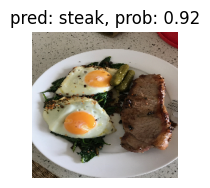

In [34]:
import matplotlib.pyplot as plt
filepath = "/content/03-steak.jpeg"
img = load_and_prep_image(filepath, scale=False) # don't scale images for EfficientNet predictions
pred_prob = myCustomModel.predict(tf.expand_dims(img, axis=0)) # model accepts tensors of shape [None, 224, 224, 3]
pred_class = classesAvailable[pred_prob.argmax()] # find the predicted class 
plt.subplot(1, 3, 1)
plt.imshow(img/255.)
plt.title(f"pred: {pred_class}, prob: {pred_prob.max():.2f}",)
plt.axis(False);

###END of NOTEBOOK ㊗



---



---

